In [90]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM, MLSolver

In [2]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools

# Basic Cosmo

## Basic no space solve

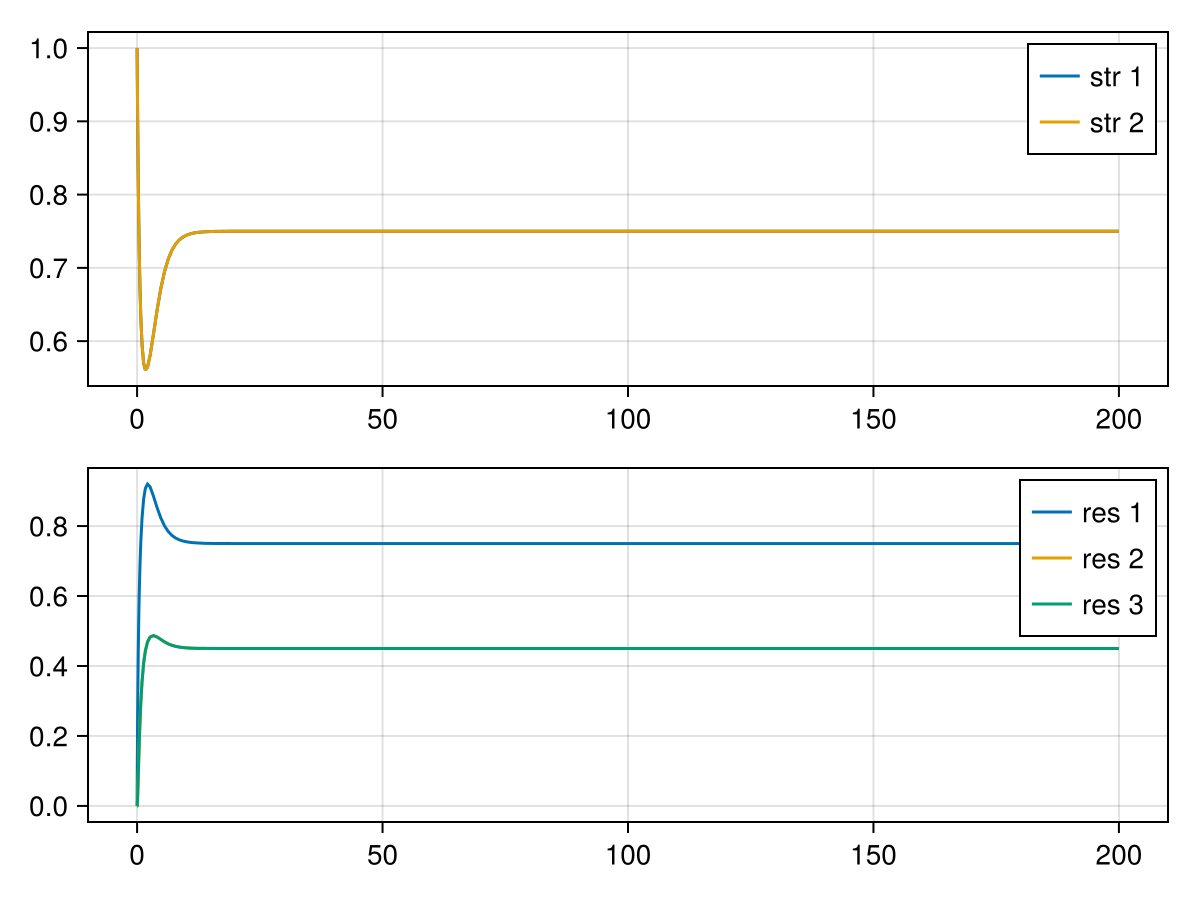

5-element Vector{Float64}:
 0.7499999950837934
 0.7499999950837934
 0.7500000042496404
 0.45000000174241855
 0.45000000174241855

In [3]:
D = fill(0., 2, 3, 3)
D[1,:,:] .= [0. 0. 0.; 0. 0. 0.; 1 0. 0.]
D[2,:,:] .= [0. 0. 0.; 1. 0. 0.; 0. 0. 0.]
p = make_mmicrm_smart(2, 3, 200;
    D=SArray{Tuple{2,3,3}}(D),
    K=[3., 0., 0.],
    r=[1., 1., 1.],
    l=[1. 0. 0.; 1. 0. 0.],
    c=[2. 2. 0.; 2. 0. 2.],
    m=[0.9, 0.9],
    u0=[1., 1., 0., 0., 0.],
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

#### Steady state solving

In [11]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


3-element Vector{Vector{Pair{Symbolics.Num, Symbolics.Num}}}:
 [u1 => 0.75, u2 => 0.75, u3 => 0.75, u4 => 0.45, u5 => 0.45]
 [u1 => 0.16666666666666666, u2 => 0.16666666666666666, u3 => 1.8, u4 => 0.45, u5 => 0.45]
 [u1 => 0.0, u2 => 0.0, u3 => 3.0, u4 => 0.0, u5 => 0.0]

In [16]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[0.7499991588608942, 0.7499991588608942, 0.7500007386390256, 0.4500002918297526, 0.4500002918297526]

## Linear stability analysis

In [4]:
ks = LinRange(0., 10., 10000)
Ds = [0.01, 0.01, 1e2, 1., 1.]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[2.613627797042001e-9, 2.613627797042001e-9, -2.2499420104793444e-9, -9.313096960283929e-10, -9.313096960283929e-10]

maximum(real(lambdas)) = 0.23503411881277064


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410


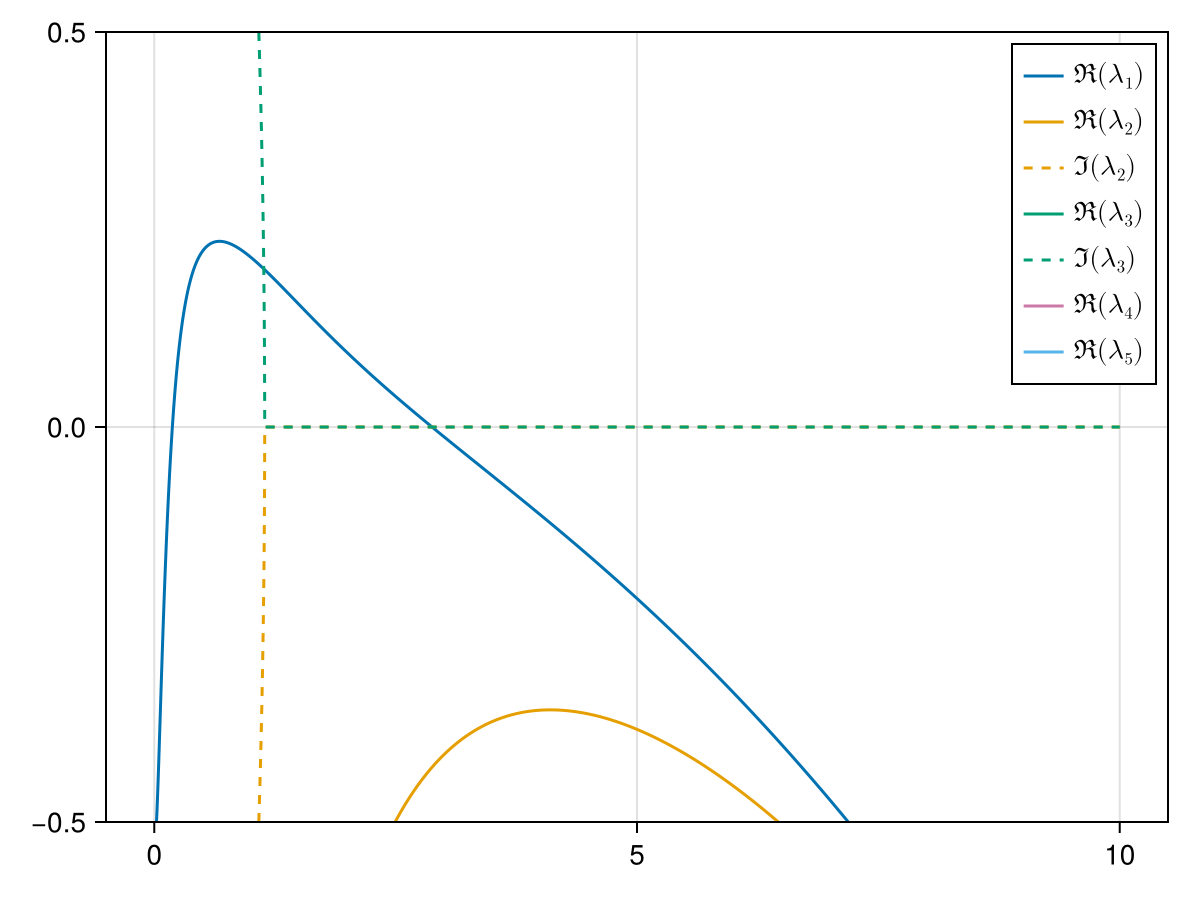

In [5]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [6]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(676, 0.6750675067506751)

In [7]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

5-element Vector{ComplexF64}:
   0.6976388793421477 + 0.0im
   0.6976388793421481 + 0.0im
 -0.04202082925366469 + 0.0im
   0.1114321272553347 + 0.0im
  0.11143212725533479 + 0.0im

## Spatial stuff - 1D!

In [86]:
ssize = (4000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.05, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((5, 4000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.05]))

#### Direct solver

  6.840486 seconds (467.88 k allocations: 1.452 GiB, 4.31% gc time)


ReturnCode.Success = 1

941

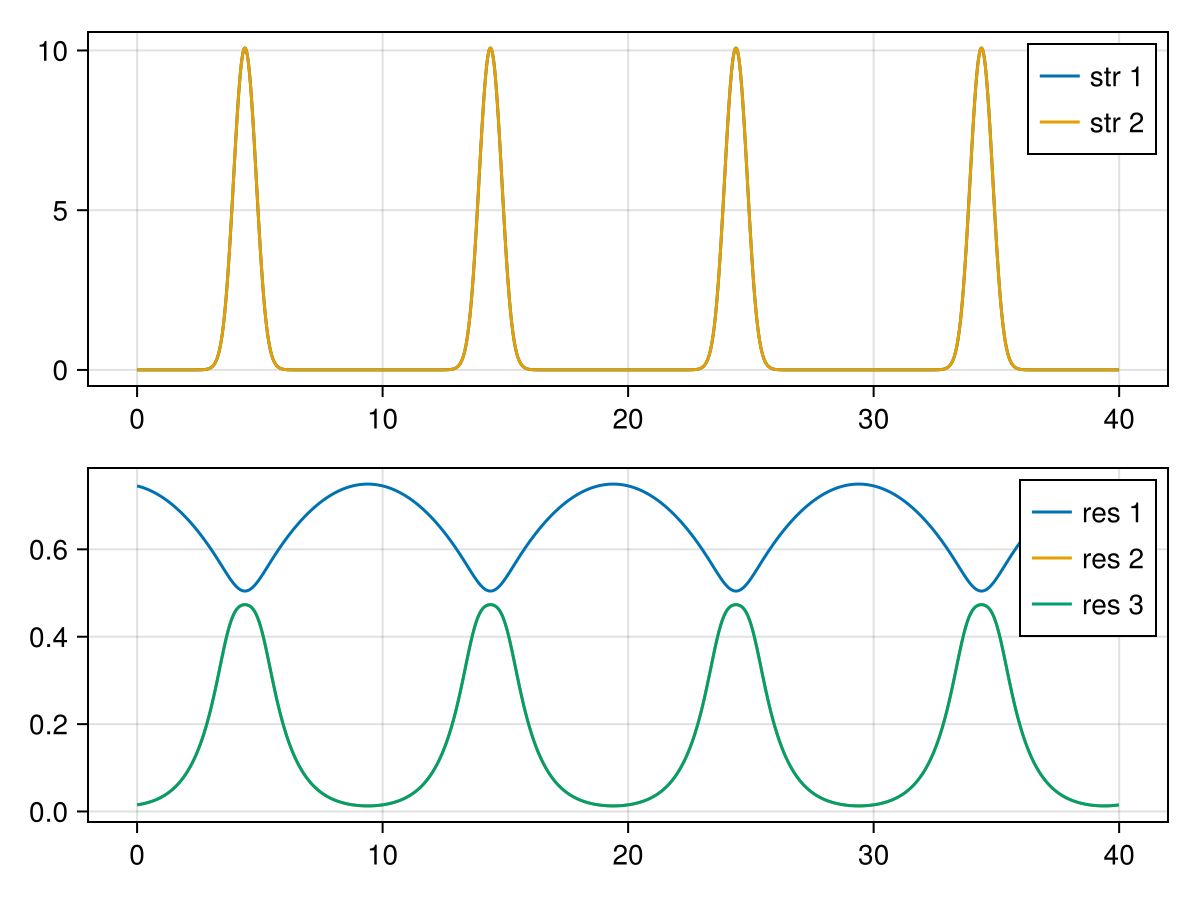

In [83]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

In [84]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  941
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    69
Number of linear solves:                           573
Number of Jacobians created:                       13
Number of nonlinear solver iterations:             456
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          196
Number of rejected steps:                          6

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

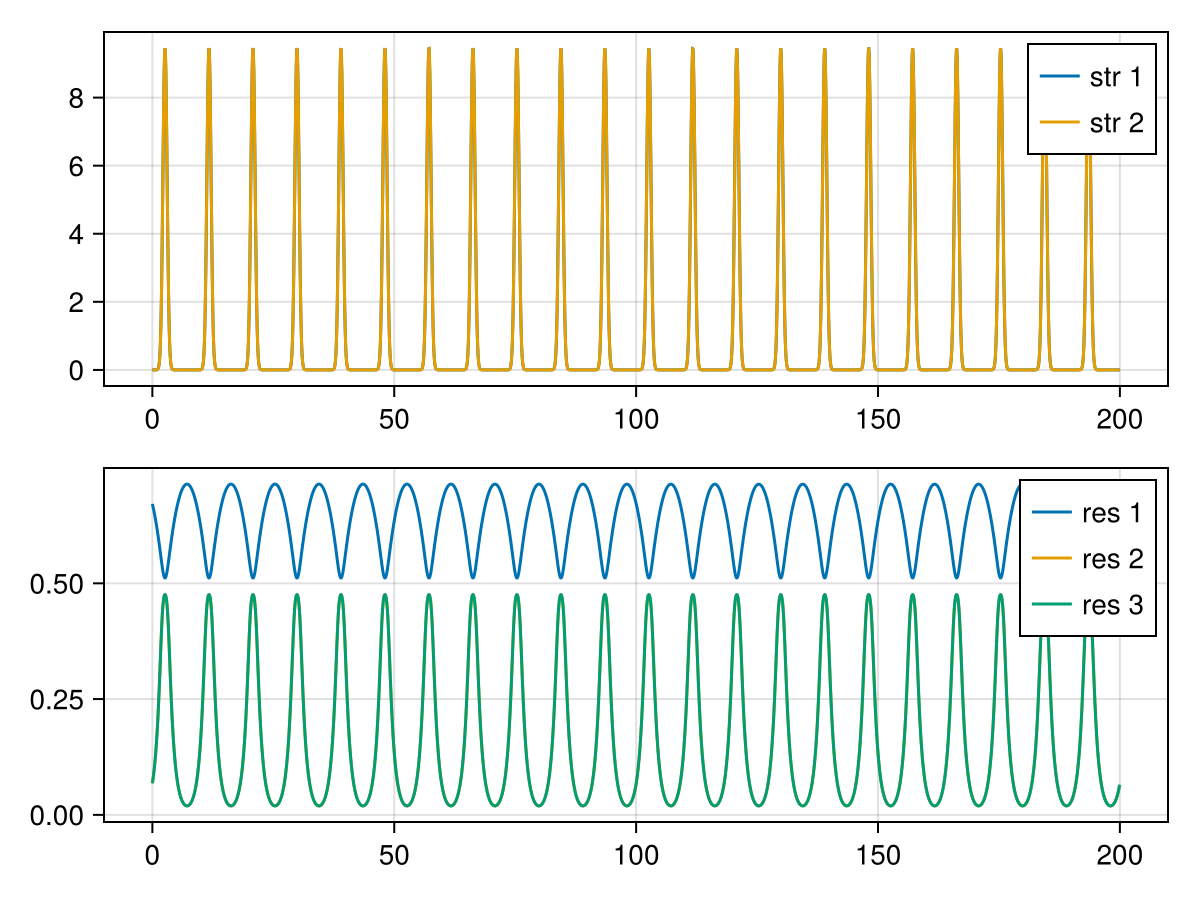

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [194]:
ssize = (50,50)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.2, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((5, 50, 50), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.2, 0.2]))

#### Direct solver

In [195]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
#plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

 22.400503 seconds (372.71 k allocations: 2.978 GiB, 0.20% gc time)


ReturnCode.Success = 1

1102

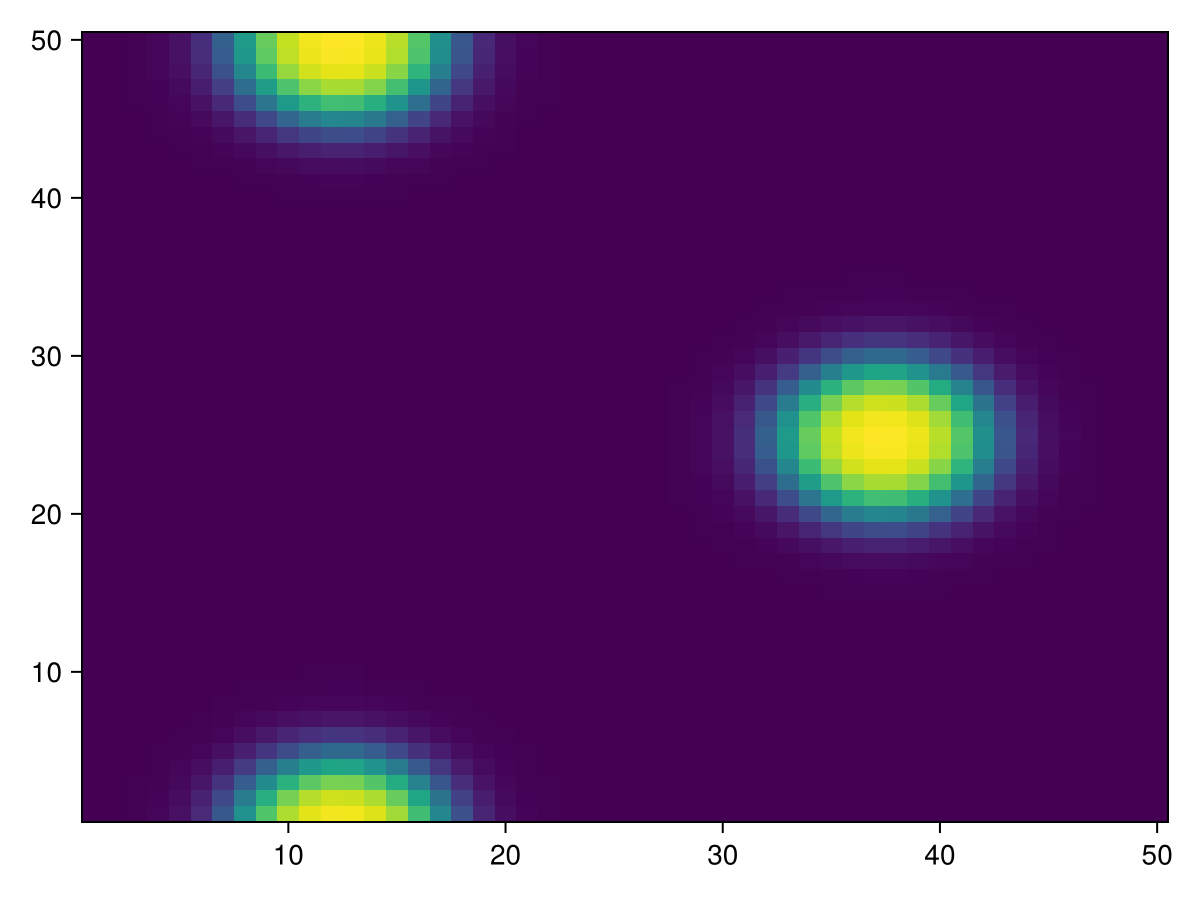

In [196]:
heatmap(sps(10000)[1,:,:])

In [197]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  1102
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    60
Number of linear solves:                           626
Number of Jacobians created:                       15
Number of nonlinear solver iterations:             486
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          188
Number of rejected steps:                          5

# Extras

In [165]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()